In [24]:
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import randint, loguniform

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    f1_score, ConfusionMatrixDisplay,
    confusion_matrix, roc_curve, roc_auc_score, make_scorer,
    classification_report, log_loss
)

In [25]:
df = pd.read_csv('../data/processed/pulsar_processed.csv')
df.head()

,PC1,PC2,PC3,PC4,PC5,target_class
0,-1.278849,1.273133,0.016213,0.662102,0.577362,0
1,-1.020553,0.201162,0.670478,1.605779,-0.390326,0
2,0.188289,-0.432114,-0.979766,-0.519232,-0.305346,0
3,-1.015466,1.469881,-0.018832,0.938386,0.495189,0
4,-0.822626,-2.123651,0.407953,-0.380922,-0.654083,0


In [26]:
X = df.drop(columns=['target_class'])
y = df['target_class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

## Gradient Boosting

### Baseline Model

In [27]:
gb_baseline = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    random_state=42,
)

gb_baseline.fit(X_train, y_train)

,loss,'log_loss'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [28]:
y_pred = gb_baseline.predict(X_test)

y_pred_proba = gb_baseline.predict_proba(X_test)[:, 1]

In [29]:
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      3252
           1       0.94      0.84      0.88       328

    accuracy                           0.98      3580
   macro avg       0.96      0.91      0.94      3580
weighted avg       0.98      0.98      0.98      3580



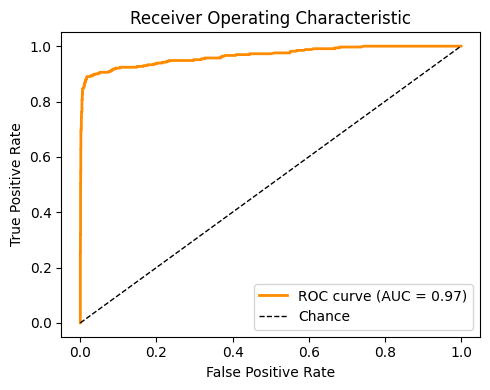

In [30]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', lw=1, label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

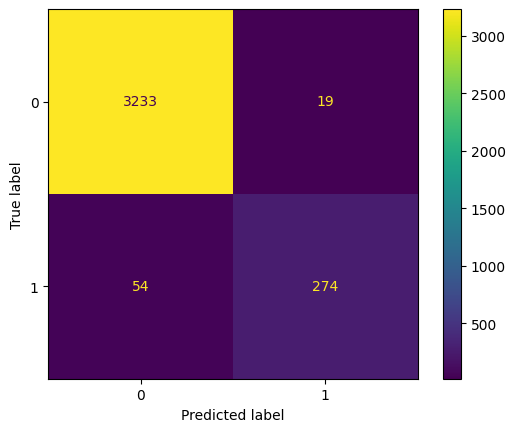

In [31]:
cm = confusion_matrix(y_test, y_pred)
fig = ConfusionMatrixDisplay(cm)
fig.plot()

In [32]:
print(f'Log  Loss: {log_loss(y_test, y_pred_proba):.4f}')

Log  Loss: 0.0809


### Hyperparameter Tuning with Randomized Search and CV

In [33]:
param_dist = {
    'n_estimators': randint(100, 1000),
    'learning_rate': loguniform(1e-3, 0.3),
    'max_depth': randint(3, 10),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2']
}

In [34]:
gb_model_cv = GradientBoostingClassifier(random_state=42)
kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scorer = make_scorer(f1_score, pos_label=1)

random_search = RandomizedSearchCV(
    estimator=gb_model_cv,
    param_distributions=param_dist,
    n_iter=10,
    scoring=scorer,
    cv=kfolds,
)

In [35]:
random_search.fit(X_train, y_train)

,estimator,GradientBoost...ndom_state=42)
,param_distributions,"{'learning_rate': <scipy.stats....t 0x11da9d100>, 'max_depth': <scipy.stats....t 0x11db689b0>, 'max_features': ['sqrt', 'log2'], 'min_samples_leaf': <scipy.stats....t 0x11db68ad0>, ...}"
,n_iter,10
,scoring,"make_scorer(f..., pos_label=1)"
,n_jobs,None
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [36]:
"""
Best params: {'learning_rate': np.float64(0.02953650734143353), 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 7, 'n_estimators': 603}
Best cross-validated F1 score: 0.8708
"""
best_model = random_search.best_estimator_
best_params = random_search.best_params_

print(f'Best params: {best_params}')
best_score = random_search.best_score_
print(f'Best cross-validated F1 score: {best_score:.4f}')

Best params: {'learning_rate': np.float64(0.02953650734143353), 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 7, 'n_estimators': 603}
Best cross-validated F1 score: 0.8708


In [37]:
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      3252
           1       0.93      0.83      0.88       328

    accuracy                           0.98      3580
   macro avg       0.95      0.91      0.93      3580
weighted avg       0.98      0.98      0.98      3580



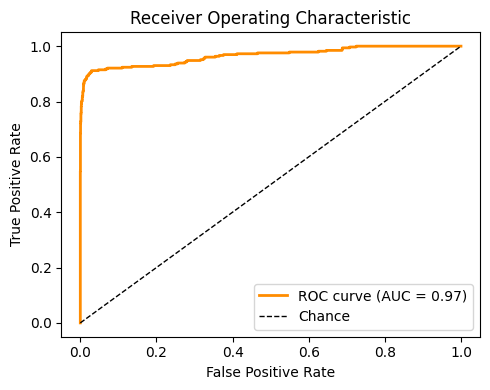

In [38]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', lw=1, label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

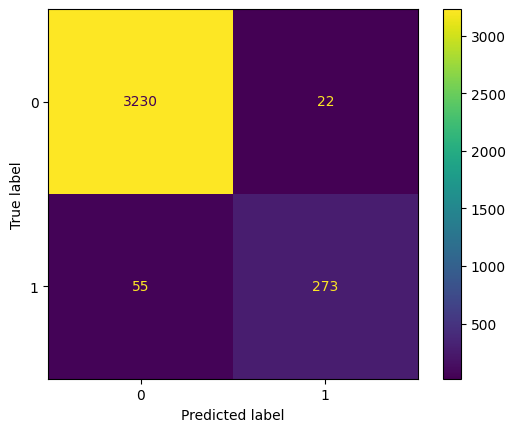

In [39]:
cm = confusion_matrix(y_test, y_pred)
fig = ConfusionMatrixDisplay(cm)
fig.plot()

In [40]:
# Export the best model
import joblib
joblib.dump(best_model, '../models/gb_best_model.pkl')

['../models/gb_best_model.pkl']